In [1]:
import os
import keras
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization
from keras.optimizers import SGD, RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [2]:
# Put training data into a DataFrame        
X = pd.read_csv('/kaggle/input/Kannada-MNIST/train.csv')
# X_test = pd.read_csv('/kaggle/input/Kannada-MNIST/test.csv')
# Separate the label column
y = X.loc[:]['label']
# Drop label column
X.drop('label', axis=1, inplace=True)

In [3]:
# Create train and test data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=42)
print('X_train shape: {0}'.format(X_train.shape))
print('X_val shape: {0}'.format(X_val.shape))
print('y_train shape: {0}'.format(y_train.shape))
print('y_val shape: {0}'.format(y_val.shape))

X_train shape: (51000, 784)
X_val shape: (9000, 784)
y_train shape: (51000,)
y_val shape: (9000,)


In [4]:
# Labels are equally distributed (10% each)
print(y.value_counts(normalize=True))

9    0.1
8    0.1
7    0.1
6    0.1
5    0.1
4    0.1
3    0.1
2    0.1
1    0.1
0    0.1
Name: label, dtype: float64


In [5]:
num_classes = 10
# Reshape training data
num_samples_train = X_train.shape[0]
num_samples_val = X_val.shape[0]
X_train = X_train.to_numpy().reshape(num_samples_train, 28, 28, 1)
X_val = X_val.to_numpy().reshape(num_samples_val, 28, 28, 1)

# Data Augmentation
train_datagen = ImageDataGenerator(rescale=1./255.,
                                   rotation_range=20,
                                   width_shift_range=0.25,
                                   height_shift_range=0.25,
                                   shear_range=0.2,
                                   zoom_range=0.25,
                                   horizontal_flip=False)

val_datagen = ImageDataGenerator(rescale=1./255.)

y_train = y_train.to_numpy()
y_val = y_val.to_numpy()

# Convert class vector to binary class matrix
y_train = keras.utils.to_categorical(y_train, num_classes=num_classes, dtype='float32')
y_val = keras.utils.to_categorical(y_val, num_classes=num_classes, dtype='float32')

[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


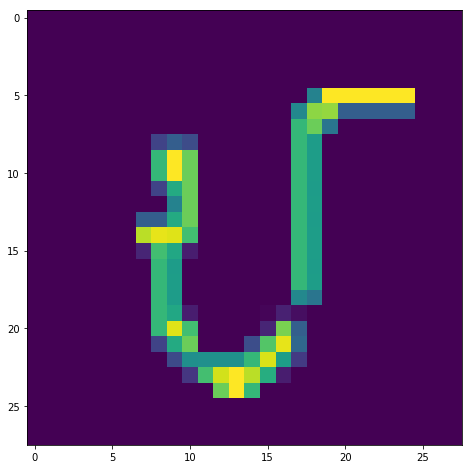

In [6]:
%matplotlib inline
img = X_train[4].reshape(28,28)
plt.figure(figsize=(8,8))
plt.imshow(img)
print(y_val[4])

In [7]:
# Build up our model
def create_model(lr, show_summary=False):
    
    model = Sequential()
    model.add(Conv2D(64, (3,3), activation='relu', input_shape=(28, 28, 1)))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3,3), activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (5,5), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.15))
    
    model.add(Conv2D(128, (3,3), activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3,3), activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (5,5), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.15))
    
    model.add(Conv2D(256, (3,3), activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(256, (5,5), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.15))
    
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(10, activation='softmax'))
    
    if show_summary:
        model.summary()
        
    optimizer = RMSprop(lr=learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['acc'])
    
    return model

In [8]:
def train_model(model, X_train, y_train, X_val, y_val, epochs, batch_size, verbose):
    
    learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=200,
                                            verbose=verbose,
                                            factor=0.2)
    
    # Early Stopping
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=verbose, patience=200)

    history = model.fit_generator(train_datagen.flow(X_train, y_train, batch_size=batch_size),
                                  steps_per_epoch=200, 
                                  epochs=epochs, 
                                  validation_data=val_datagen.flow(X_val, y_val), 
                                  validation_steps=50, 
                                  callbacks=[learning_rate_reduction, es])
    

    # val_loss, val_acc = model.evaluate(X_val, y_val)
    # print("Test accuracy: {0}".format(val_acc))
    return history

In [9]:
# Test our model
batch_size = 512
epochs = 65
learning_rate = 0.001

model = create_model(learning_rate, show_summary=True)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 64)        640       
_________________________________________________________________
batch_normalization_1 (Batch (None, 26, 26, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        36928     
_________________________________________________________________
batch_normalization_2 (Batch (None, 24, 24, 64)        256       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 64)        102464    
_________________________________________________________________
batch_normalization_3 (Batch (None, 24, 24, 64)        256       
_________________________________________________________________
dropout_1 (Dropout)          (None, 24, 24, 64)       

In [10]:
history = train_model(model, X_train, y_train, X_val, y_val, epochs, batch_size, 1)

Epoch 1/65
200/200 [==============================] - 52s 260ms/step - loss: 0.4544 - acc: 0.8509 - val_loss: 45.7768 - val_acc: 0.0950
Epoch 2/65
200/200 [==============================] - 42s 208ms/step - loss: 0.1026 - acc: 0.9667 - val_loss: 57.6798 - val_acc: 0.0962
Epoch 3/65
200/200 [==============================] - 42s 209ms/step - loss: 0.0734 - acc: 0.9767 - val_loss: 11.2861 - val_acc: 0.2631
Epoch 4/65
200/200 [==============================] - 42s 208ms/step - loss: 0.0597 - acc: 0.9810 - val_loss: 0.0072 - val_acc: 0.9912
Epoch 5/65
200/200 [==============================] - 42s 208ms/step - loss: 0.0517 - acc: 0.9834 - val_loss: 0.0130 - val_acc: 0.9925
Epoch 6/65
200/200 [==============================] - 42s 211ms/step - loss: 0.0448 - acc: 0.9858 - val_loss: 0.0084 - val_acc: 0.9956
Epoch 7/65
200/200 [==============================] - 42s 211ms/step - loss: 0.0414 - acc: 0.9868 - val_loss: 0.0419 - val_acc: 0.9969
Epoch 8/65
200/200 [==============================] 

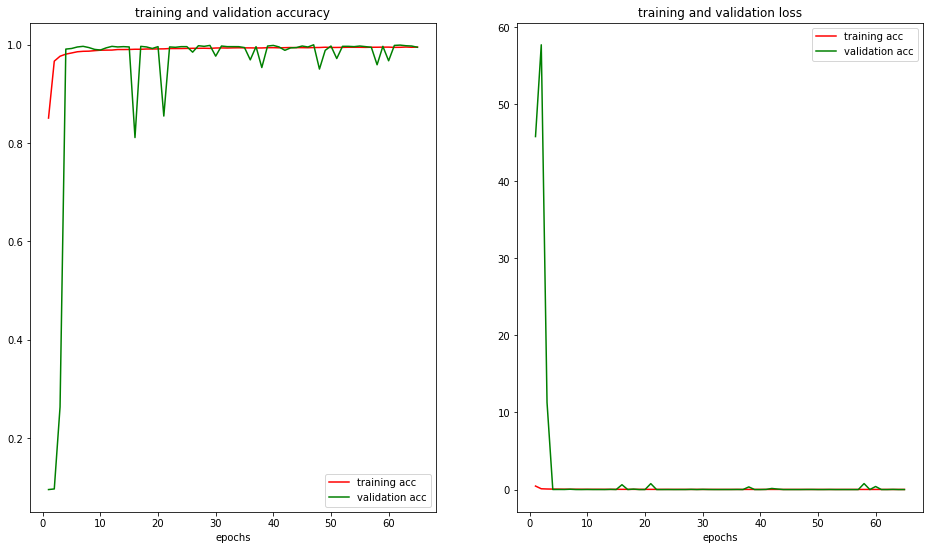

In [11]:
# Display curves of accuracy and learning
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16,9))
axs[0].plot(epochs, acc, 'r', label='training acc')
axs[0].plot(epochs, val_acc, 'g', label='validation acc')
axs[0].set_title('training and validation accuracy')
axs[0].set_xlabel('epochs')
axs[0].legend()

axs[1].plot(epochs, loss, 'r', label='training acc')
axs[1].plot(epochs, val_loss, 'g', label='validation acc')
axs[1].set_title('training and validation loss')
axs[1].set_xlabel('epochs')
axs[1].legend()

plt.show()

In [12]:
# Load and prepare the test data
test = pd.read_csv("../input/Kannada-MNIST/test.csv")
x_test = test.drop('id', axis=1).iloc[:,:].values
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

predictions = model.predict_classes(x_test/255.)
submission = pd.read_csv('../input/Kannada-MNIST/sample_submission.csv')
submission['label'] = predictions
submission.to_csv("submission.csv", index=False)